# **What Should I Serve?**
## **A Study of Restaurants in Mumbai Neighborhoods**
**Completed in partial completion of IBM's Data Science Professional Certification - Vikash Kumar**
### **Introduction**
Imagine for a moment that you are an restaurantuer looking for new opportunties in the city of Mumbai, India. You know that the city is famous the world over for the lively food scene, and you cannot imagine opening your new venture anywhere else. There is a downside to going to such a popular food desitnation, however. There are already hundreds, if not thousands, of thriving restaurants competing for local and tourist dollars alike. YOu know that you have to find some way to stand out in the crowd. How can you find that 'x factor' to make your new restaurant different from all the others?

Data Science, of course! You decide that that what you need to do is get a deeper look at the restaurants currently serving the diverse and liveley neighborhoods in Mumbai. Each area of the city is home to restaurants serving diffrent menus to different clientle. In order to stand out from the crowd, you need to know what each neighborhood contains, and what each neighborhood lacks. Your plan is to find an area the Big Easy that isn't too crowded, but still has thriving businesses, and then to open up a new eatery that is serving something unlike all the others.

#### **Key Questions:**

How many restaraunts are in each of the neighborhoods in Mumbai?
What type of food do those restraunts serve?
Where is there room in the market for something new?
What would be a unique food to serve in that neighborhood?
### **About the Data**
Based on the questions we are trying to answer, we need to collect data on a few different topics. First, we need to know more about the neighborhoods of Mumbai. Luckily, **Wikipedia** has a very helpful [table of all the neighborhoods and thier geographic coordinates](https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai) that we can use.

Next, we need to be able to identify the number and type of restraunts in a given neighborhood. We will use the Foursquare API to help us find and identify this information. This API will allow us to search for businesses and venues around a given geogrpahic point (like the neighborhood information from Wikipedia) and find out how many and what types of businesses are in that area. We will clean that up and group it to make an easier to follow listing of business types, then remove anything that isn't a restaurant for final analysis.

Finally, we will combine this information and perform analysis and visualization techniques using pandas, numpy, folium and other packages to decide how densely packed a neighborhood is with restaurants as well as to idenify the types of restaurants that are located in each neighborhood. We will use k-means clustering to examine the commonality of types of restaurants and provide raw counts of businesses for consideration.

In the end, we should be able to develop a simple search and retrieve function that allows you to input a neighborhood name, and get back an interactive map with the information you are looking for.

### **Step Zero: Set-up**
Before we start importing data, we need to intialize the notebook with all the libraries we are going to need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy # uncomment this line if you need to isntall geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium # uncomment this line if you need to install folium
import folium # map rendering library

import urllib.parse, urllib.error # library to handle url parsing for webscraping
from urllib.request import urlopen

!pip install beautifulsoup4 # uncomment this line if you need to install beautifulsoup
from bs4 import BeautifulSoup

!pip install WordCloud
from wordcloud import WordCloud, STOPWORDS 

print('Libraries imported.')

     |████████████████████████████████| 112kB 5.0MB/s eta 0:00:01
     |████████████████████████████████| 122kB 3.3MB/s eta 0:00:01
     |████████████████████████████████| 368kB 3.7MB/s eta 0:00:01
Libraries imported.


### **Step One: Neighborhoods**
The first thing we need to do is parse the Wikipedia article for the coordinates of the neighborhoods. We can do that using BeautifulSoup and urllib.

We will start by finding table that contains our data with the help of 'find_all' method in BeautifulSoup. We set an empty arrays for data storage, and then populate the same with the help of 'for' loop.

In [2]:
data = [] # empty list for storing information

# Request a local copy of the Article
url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai'
html = urlopen(url) 
soup = BeautifulSoup(html, 'html.parser')

tables = soup.find_all('table')

#Create array to hold the data we extract
area = []
location = []
latitude = []
longitude = []

# Only 1st table contains data, we desire for this project
rows = tables[0].find_all('tr')

for row in rows:
    cells = row.find_all('td')
    if len(cells) > 1:
        area.append(cells[0].text.strip())
        location.append(cells[1].text.strip())
        latitude.append(cells[2].text.strip())
        longitude.append(cells[3].text.strip())

We can now go ahead and make a pandas dataframe of this information, as that will be easier to read and work with moving forward.

In [3]:
# Creating a desired dataframe
data = np.array([area, location, latitude, longitude])
# The dataframe will consist of four columns: 'Area', 'Location', 'Latitude', 'Longitude'
column_values = ['Area', 'Location', 'Latitude', 'Longitude']
mum_neigh = pd.DataFrame(data = data.T, columns = column_values)
mum_neigh['Latitude'] = mum_neigh['Latitude'].astype(float)
mum_neigh['Longitude'] = mum_neigh['Longitude'].astype(float)

mum_neigh.head()

,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270


**Get the Latitude and Longitude of Mumbai**

We can easily do this with the Geopy library. We will need a user agent, which we are calling 'pelican'.

In [4]:
address = 'Mumbai, Mahārāshtra, India'

geolocator = Nominatim(user_agent="pelican")
location = geolocator.geocode(address)
mum_lat = location.latitude
mum_lng = location.longitude

print('The geograpical coordinates of Mumbai are {}, {}.'.format(mum_lat, mum_lng))

The geograpical coordinates of Mumbai are 18.9387711, 72.8353355.


**Build a map of Mumbai and overlay the Neighbohoods**

Now that we have all this data, we can make a map of the city and look at the neighborhoods. We will use the folium library for that.

In [5]:
# create map of Mumbai using latitude and longitude values
map_mum = folium.Map(location=[mum_lat, mum_lng], zoom_start=10)

# add markers to map
for lat, lng, ar, loc in zip(mum_neigh['Latitude'], mum_neigh['Longitude'], mum_neigh['Area'], mum_neigh['Location']):
    label = '{}, {}'.format(ar, loc)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mum)  
    
map_mum

### **Step Two: Restaurants**
Now that we can locate and identify all of the neighborhoods in Mumbai, it is time to begin looking for all the restaraunts in those neighborhoods. This is going to take some integration with the FourSquare API.

In a hidden cell, I have set my API key and other information. You will need to set your own to replicate this project.

In [6]:
# The code was removed by Vikash Kumar for sharing.
CLIENT_ID = 'GGVVYI54OJR5J4HJMMX0P5TT4JOYFOIJI00N1EVGDJG4SQKG' # your Foursquare ID
CLIENT_SECRET = 'XNRFBK4RBQCCBNCZGQKS4NBT2QIR4GRHU0VPBY2STBDTUOIJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GGVVYI54OJR5J4HJMMX0P5TT4JOYFOIJI00N1EVGDJG4SQKG
CLIENT_SECRET:XNRFBK4RBQCCBNCZGQKS4NBT2QIR4GRHU0VPBY2STBDTUOIJ


Let's start by examining one neighborhood. We will use the **Juhu, Western Suburbs** for this intiital run. First, we need the coordinates of the neighborhood.

In [7]:
neigh_num = 21 # For Juhu in the dataframe
neighborhood_latitude = mum_neigh.loc[neigh_num, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = mum_neigh.loc[neigh_num, 'Longitude'] # neighborhood longitude value

neighborhood_name = '{}, {}'.format(mum_neigh.loc[neigh_num, 'Area'], mum_neigh.loc[neigh_num, 'Location']) # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Juhu, Western Suburbs are 19.1, 72.83.


With this in hand, we can look at the top 100 venues within 1 kilometer (1000 meters) of the Juhu, Western Suburbs. We will save that information in results.

In [8]:
radius = 1000
LIMIT = 100

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()


Based on our understanding of the FourSquare API, we want only the information in the items key. We also know we need the venue category types. We can address those needs now.

In [9]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Starbucks,Coffee Shop,19.100479,72.827438
1,Soho House,Club House,19.095805,72.829070
2,TrueTrammTrunk,Bar,19.103452,72.831413
3,Mahesh Lunch Home,Seafood Restaurant,19.103680,72.826794
4,Gajalee,Seafood Restaurant,19.103827,72.831028


Exactly how many venues did we find in the Juhu?

In [11]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

77 venues were returned by Foursquare.


Okay, we maxed it out. However, we aren't done here. As you can see, we may have venues that don't fit out target data set (other than food venue). Let's work on filtering that down.

Luckily, the FourSquare API has a filter feature and we can pick a [Venue Category](https://developer.foursquare.com/docs/build-with-foursquare/categories/) to filter by. Let's use Food, which has an id of 4d4b7105d754a06374d81259.

In [12]:
radius = 1000
LIMIT = 100
catId = '4d4b7105d754a06374d81259' # Category ID for 'Food.' This will return all sub-categories'

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    catId, # add the category ID to the URL
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Mahesh Lunch Home,Seafood Restaurant,19.103680,72.826794
1,Gajalee,Seafood Restaurant,19.103827,72.831028
2,Lotus Café,Indian Restaurant,19.101772,72.825664
3,Arola @ JW Marriott,Spanish Restaurant,19.101647,72.825477
4,Prithvi Cafe,Café,19.106153,72.825866


That looks much better. Let's see how many Food venues we found in the French Quarter.

In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

59 venues were returned by Foursquare.


Again, we found 100, which is our max. We may need to update the limit but we will see. It could be that you don't want to be in a neighborhood with that many restaurants competing for customers!

### **Expand the search to all Neighborhoods.**
Now, we need to run the search through every neighborhood in Mumbai. Let's do that by building a function.

In [14]:
def getNearbyVenues(areas, locations, latitudes, longitudes, catId, radius=1000):
    
    venues_list=[]
    for ar, loc, lat, lng in zip(areas, locations, latitudes, longitudes):
        name = ar + ', ' + loc
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            catId,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

You'll notice that we made the category id a variable in the function. We can pass it different IDs should we wish to narrow our searches.

Now we can run the function on all the neighborhoods and build a dataframe with the results.

In [15]:
mum_rests = getNearbyVenues(areas=mum_neigh['Area'],
                                locations=mum_neigh['Location'],
                                latitudes=mum_neigh['Latitude'],
                                longitudes=mum_neigh['Longitude'],
                                catId='4d4b7105d754a06374d81259')
print(mum_rests.shape)
mum_rests.head()

Amboli, Andheri,Western Suburbs
Chakala, Andheri, Western Suburbs
D.N. Nagar, Andheri,Western Suburbs
Four Bungalows, Andheri,Western Suburbs
Lokhandwala, Andheri,Western Suburbs
Marol, Andheri,Western Suburbs
Sahar, Andheri,Western Suburbs
Seven Bungalows, Andheri,Western Suburbs
Versova, Andheri,Western Suburbs
Mira Road, Mira-Bhayandar,Western Suburbs
Bhayandar, Mira-Bhayandar,Western Suburbs
Uttan, Mira-Bhayandar,Western Suburbs
Bandstand Promenade, Bandra,Western Suburbs
Kherwadi, Bandra,Western Suburbs
Pali Hill, Bandra,Western Suburbs
I.C. Colony, Borivali (West),Western Suburbs
Gorai, Borivali (West),Western Suburbs
Dahisa, Western Suburbs
Aarey Milk Colony, Goregaon,Western Suburbs
Bangur Nagar, Goregaon,Western Suburbs
Jogeshwari West, Western Suburbs
Juhu, Western Suburbs
Charkop, Kandivali West,Western Suburbs
Poisar, Kandivali West,Western Suburbs
Mahavir Nagar, Kandivali West,Western Suburbs
Thakur village, Kandivali East,Western Suburbs
Pali Naka, Khar,Western Suburbs
Kh

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Amboli, Andheri,Western Suburbs",19.1293,72.8434,Shawarma Factory,19.124591,72.840398,Falafel Restaurant
1,"Amboli, Andheri,Western Suburbs",19.1293,72.8434,Cafe Arfa,19.128930,72.847140,Indian Restaurant
2,"Amboli, Andheri,Western Suburbs",19.1293,72.8434,Jaffer Bhai's Delhi Darbar,19.137714,72.845909,Mughlai Restaurant
3,"Amboli, Andheri,Western Suburbs",19.1293,72.8434,"5 Spice , Bandra",19.130421,72.847206,Chinese Restaurant
4,"Amboli, Andheri,Western Suburbs",19.1293,72.8434,Pizza Express,19.131893,72.834668,Pizza Place


We found 3105 restaurants in the City of Mumbai. Let's see how that looks per neighborhood. But before that let's pickle out our result for future use.

In [16]:
mum_rests[['Neighborhood', 'Venue']].groupby('Neighborhood').count().reset_index().head()

,Neighborhood,Venue
0,"Aarey Milk Colony, Goregaon,Western Suburbs",5
1,"Agripada, South Mumbai",22
2,"Altamount Road, South Mumbai",69
3,"Amboli, Andheri,Western Suburbs",29
4,"Amrut Nagar, Ghatkopar,Eastern Suburbs",40


Before we move on to normalization and analysis, let's see how many different kinds of food venues we found.

In [17]:
print('There are {} unique types of restaurants in Mumbai.'.format(len(mum_rests['Venue Category'].unique())))

There are 76 unique types of restaurants in Mumbai.


Let's see if any restaurants category is dominating among others.

In [18]:
mum_rests[['Venue Category', 'Venue']].groupby('Venue Category').count().sort_values(by=['Venue'], ascending=False).reset_index().head()

,Venue Category,Venue
0,Indian Restaurant,719
1,Café,280
2,Fast Food Restaurant,246
3,Chinese Restaurant,195
4,Bakery,184


### **Step Three: Data Normalization and Analysis**
We are going to start by doing one hot encoding, where we will use each category type as a column name, and value will either be 0 or 1, representing a binary True or False. This makes it easier to do analysis down the line.

In [20]:
# one hot encoding
mum_onehot = pd.get_dummies(mum_rests[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mum_onehot['Neighborhood'] = mum_rests['Neighborhood']

# move neighborhood column to the first column
first_col = ['Neighborhood']
fixed_columns = [col for col in mum_onehot if col not in first_col]
mum_onehot = mum_onehot[first_col + fixed_columns]

mum_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bengali Restaurant,Bistro,Breakfast Spot,Buffet,Burger Joint,Cafeteria,Café,Chaat Place,Chinese Restaurant,Comfort Food Restaurant,Creperie,Deli / Bodega,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Goan Restaurant,Greek Restaurant,Halal Restaurant,Hot Dog Joint,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Irani Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Maharashtrian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Parsi Restaurant,Pizza Place,Portuguese Restaurant,Punjabi Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South Indian Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant
0,"Amboli, Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Amboli, Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Amboli, Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Amboli, Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Amboli, Andheri,Western Suburbs",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we are going to group the rows by Neighborhood and get the frequency mean for each category.

In [21]:
mum_groups = mum_onehot.groupby('Neighborhood').mean().reset_index()
mum_groups.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bengali Restaurant,Bistro,Breakfast Spot,Buffet,Burger Joint,Cafeteria,Café,Chaat Place,Chinese Restaurant,Comfort Food Restaurant,Creperie,Deli / Bodega,Dhaba,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Goan Restaurant,Greek Restaurant,Halal Restaurant,Hot Dog Joint,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Irani Cafe,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Maharashtrian Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Mughlai Restaurant,Multicuisine Indian Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Parsi Restaurant,Pizza Place,Portuguese Restaurant,Punjabi Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South Indian Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant
0,"Aarey Milk Colony, Goregaon,Western Suburbs",0.000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.200000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.400000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.200000,0.000000,0.000000,0.0,0.200000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000
1,"Agripada, South Mumbai",0.000,0.000,0.045455,0.000000,0.0,0.181818,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.136364,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.045455,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.318182,0.0,0.0,0.0,0.000000,0.045455,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.000,0.181818,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000
2,"Altamount Road, South Mumbai",0.000,0.000,0.000000,0.000000,0.0,0.086957,0.014493,0.0,0.014493,0.0,0.000000,0.014493,0.101449,0.0,0.101449,0.0,0.0,0.028986,0.0,0.0,0.014493,0.014493,0.0,0.0,0.014493,0.072464,0.0,0.0,0.028986,0.0,0.028986,0.014493,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.115942,0.0,0.0,0.0,0.043478,0.014493,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.057971,0.0,0.000,0.072464,0.014493,0.072464,0.0,0.028986,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.028986
3,"Amboli, Andheri,Western Suburbs",0.000,0.000,0.103448,0.034483,0.0,0.034483,0.000000,0.0,0.000000,0.0,0.034483,0.000000,0.000000,0.0,0.068966,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.034483,0.068966,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.034483,0.000,0.0,0.275862,0.0,0.0,0.0,0.034483,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.068966,0.0,0.0,0.0,0.0,0.0,0.103448,0.0,0.000,0.000000,0.000000,0.034483,0.0,0.034483,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.034483
4,"Amrut Nagar, Ghatkopar,Eastern Suburbs",0.025,0.025,0.050000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.025000,0.175000,0.0,0.050000,0.0,0.0,0.000000,0.0,0.0,0.050000,0.000000,0.0,0.0,0.025000,0.075000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.025,0.0,0.0,0.0,0.0,0.000000,0.025,0.0,0.150000,0.0,0.0,0.0,0.025000,0.000000,0.0,0.0,0.025,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.075000,0.0,0.025,0.050000,0.000000,0.025000,0.0,0.000000,0.0,0.0,0.0,0.025,0.0,0.0,0.0,0.050000


Now we have some choices to consider. How many of the Top ceategories for each neighborhood are we interested in? 10 seems like a fair number, and we can always come back and increase it, so we will start there. Let's define a function first.

In [22]:
# function to find and return most x most top venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


Now we can make a dataframe showing the Top 10 restaraunt types for each neighborhood.

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = mum_groups['Neighborhood']

for ind in np.arange(mum_groups.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mum_groups.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aarey Milk Colony, Goregaon,Western Suburbs",Indian Restaurant,Restaurant,Café,Snack Place,Vegetarian / Vegan Restaurant,Diner,Donut Shop,Dumpling Restaurant,English Restaurant,Falafel Restaurant
1,"Agripada, South Mumbai",Indian Restaurant,Bakery,Restaurant,Chinese Restaurant,Asian Restaurant,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Vegetarian / Vegan Restaurant,Fish & Chips Shop
2,"Altamount Road, South Mumbai",Indian Restaurant,Chinese Restaurant,Café,Bakery,Sandwich Place,Fast Food Restaurant,Restaurant,Pizza Place,Italian Restaurant,Vegetarian / Vegan Restaurant
3,"Amboli, Andheri,Western Suburbs",Indian Restaurant,Asian Restaurant,Pizza Place,Mughlai Restaurant,Chinese Restaurant,Fast Food Restaurant,Sandwich Place,Falafel Restaurant,Italian Restaurant,Burger Joint
4,"Amrut Nagar, Ghatkopar,Eastern Suburbs",Café,Indian Restaurant,Fast Food Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Asian Restaurant,Chinese Restaurant,Diner,Restaurant,Mediterranean Restaurant


Prep the data for clustering by removing non-numerical information.

In [24]:
mum_clustering = mum_groups.drop('Neighborhood', 1)

Use the matplotlib libraries to graph values of k. Use the elbmow method to select a k value.

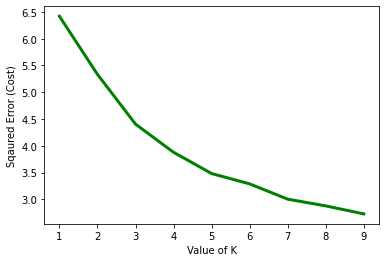

In [26]:
import matplotlib.pyplot as plt  
from matplotlib import style 

cost =[] 
max_clust = 10
for i in range(1, max_clust): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(mum_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, max_clust), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot

There isn't a clear elbow point in this graph, so we are going to use 7 becuase it looks alright.

In [27]:
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mum_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[1:10]

array([0, 3, 2, 2, 0, 0, 2, 0, 0], dtype=int32)

Let's add the cluster labels into the dataset. Then, we can look at a new map.

In [28]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mum_merge = mum_neigh
mum_merge['Neighborhood'] = mum_neigh['Area'] + ', ' + mum_neigh['Location']

# merge mum_grouped with mum_data to add latitude/longitude for each neighborhood
mum_merge = mum_merge.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

mum_merge.head() # check the last columns!

,Area,Location,Latitude,Longitude,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400,"Amboli, Andheri,Western Suburbs",2.0,Indian Restaurant,Asian Restaurant,Pizza Place,Mughlai Restaurant,Chinese Restaurant,Fast Food Restaurant,Sandwich Place,Falafel Restaurant,Italian Restaurant,Burger Joint
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833,"Chakala, Andheri, Western Suburbs",2.0,Indian Restaurant,Restaurant,Café,Seafood Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Bakery,Food Truck
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373,"D.N. Nagar, Andheri,Western Suburbs",2.0,Indian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Chinese Restaurant,Snack Place,Japanese Restaurant,Falafel Restaurant,Fast Food Restaurant,Café,Burger Joint
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210,"Four Bungalows, Andheri,Western Suburbs",2.0,Indian Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Café,Pizza Place,Restaurant,Asian Restaurant,Bakery,Diner,Japanese Restaurant
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270,"Lokhandwala, Andheri,Western Suburbs",2.0,Indian Restaurant,Pizza Place,Asian Restaurant,Café,Italian Restaurant,Seafood Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Donut Shop,Diner


Let's put this all on a map and take a look.

In [29]:
mum_merge['Cluster Labels'] = mum_merge['Cluster Labels'].fillna(0)
mum_merge['Cluster Labels'] = mum_merge['Cluster Labels'].astype(int)

# create map
map_clusters = folium.Map(location=[mum_lat, mum_lng], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mum_merge['Latitude'], mum_merge['Longitude'], mum_merge['Neighborhood'], mum_merge['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### **Step Four: Explore and Label the Clusters**
Let's look at each cluster and determine what a good way to label them would be. This will help us better understand how restaraunts are distributed throughout the city.

**Cluster 1**

In [30]:
mum_merge.loc[(mum_merge['Cluster Labels'] == 0) & 
              (mum_merge['1st Most Common Venue'].notnull()), 
              mum_merge.columns[range(4,11)]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,"Marol, Andheri,Western Suburbs",0,Indian Restaurant,Chinese Restaurant,Food,Restaurant,Vegetarian / Vegan Restaurant
18,"Aarey Milk Colony, Goregaon,Western Suburbs",0,Indian Restaurant,Restaurant,Café,Snack Place,Vegetarian / Vegan Restaurant
19,"Bangur Nagar, Goregaon,Western Suburbs",0,Indian Restaurant,Fast Food Restaurant,Pizza Place,Food Truck,Food Court
20,"Jogeshwari West, Western Suburbs",0,Indian Restaurant,Fast Food Restaurant,Restaurant,Pizza Place,Chinese Restaurant
36,"Bhandup, Eastern Suburbs",0,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Fried Chicken Joint
38,"Asalfa, Ghatkopar,Eastern Suburbs",0,Indian Restaurant,Bakery,Café,Vegetarian / Vegan Restaurant,Donut Shop
39,"Pant Nagar, Ghatkopar,Eastern Suburbs",0,Indian Restaurant,Fast Food Restaurant,Restaurant,Café,Vegetarian / Vegan Restaurant
45,"Indian Institute of Technology Bombay campus, ...",0,Indian Restaurant,Bakery,Café,Asian Restaurant,Diner
47,"Vikhroli, Eastern Suburbs",0,Indian Restaurant,Bakery,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Food
48,"Chembur, Harbour Suburbs",0,Indian Restaurant,Fast Food Restaurant,Bakery,Pizza Place,Snack Place


This cluster, clearly, looks primarly like a cluster of an Indian Cousins. 

In [31]:
mum_merge.loc[(mum_merge['Cluster Labels'] == 1) & 
              (mum_merge['1st Most Common Venue'].notnull()), 
              mum_merge.columns[range(4,11)]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
31,"Naigaon, Vasai,Western Suburbs",1,Chinese Restaurant,Vegetarian / Vegan Restaurant,Food,Donut Shop,Dumpling Restaurant


This neighborhood is in a cluster all alone, so it isn't going to be a good choice for us. We will label it as 'Bad Choice'.

In [32]:
mum_merge.loc[(mum_merge['Cluster Labels'] == 2) & 
              (mum_merge['1st Most Common Venue'].notnull()), 
              mum_merge.columns[range(4,11)]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Amboli, Andheri,Western Suburbs",2,Indian Restaurant,Asian Restaurant,Pizza Place,Mughlai Restaurant,Chinese Restaurant
1,"Chakala, Andheri, Western Suburbs",2,Indian Restaurant,Restaurant,Café,Seafood Restaurant,Vegetarian / Vegan Restaurant
2,"D.N. Nagar, Andheri,Western Suburbs",2,Indian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Chinese Restaurant,Snack Place
3,"Four Bungalows, Andheri,Western Suburbs",2,Indian Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Café,Pizza Place
4,"Lokhandwala, Andheri,Western Suburbs",2,Indian Restaurant,Pizza Place,Asian Restaurant,Café,Italian Restaurant
6,"Sahar, Andheri,Western Suburbs",2,Indian Restaurant,Fast Food Restaurant,Café,Italian Restaurant,Asian Restaurant
7,"Seven Bungalows, Andheri,Western Suburbs",2,Café,Chinese Restaurant,Indian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant
8,"Versova, Andheri,Western Suburbs",2,Indian Restaurant,Café,Chinese Restaurant,Bakery,Sandwich Place
9,"Mira Road, Mira-Bhayandar,Western Suburbs",2,Indian Restaurant,Pizza Place,Chinese Restaurant,Café,Vegetarian / Vegan Restaurant
12,"Bandstand Promenade, Bandra,Western Suburbs",2,Italian Restaurant,Asian Restaurant,Indian Restaurant,Fast Food Restaurant,Food Truck


It looks like this cluster has a good mix of options. It could be hard to find a market that stand out among all of the existing options in these neighborhoods. We will call this cluster 'Multi-Cousin'. Apart from Indian Restaurants, it has Cafe and Pizza places commonly.

In [33]:
mum_merge.loc[(mum_merge['Cluster Labels'] == 3) & 
              (mum_merge['1st Most Common Venue'].notnull()), 
              mum_merge.columns[range(4,11)]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,"Bhayandar, Mira-Bhayandar,Western Suburbs",3,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Mexican Restaurant
15,"I.C. Colony, Borivali (West),Western Suburbs",3,Bakery,Chinese Restaurant,Indian Restaurant,Fast Food Restaurant,Pizza Place
17,"Dahisa, Western Suburbs",3,Bakery,Indian Restaurant,Chinese Restaurant,Diner,Café
22,"Charkop, Kandivali West,Western Suburbs",3,Bakery,Fast Food Restaurant,Indian Restaurant,Chinese Restaurant,Pizza Place
23,"Poisar, Kandivali West,Western Suburbs",3,Food Truck,Fast Food Restaurant,Bakery,Chinese Restaurant,Snack Place
24,"Mahavir Nagar, Kandivali West,Western Suburbs",3,Fast Food Restaurant,Indian Restaurant,Bakery,Snack Place,Food
28,"Dindoshi, Malad,Western Suburbs",3,Fast Food Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Snack Place
33,"Virar, Western Suburbs",3,Fast Food Restaurant,Indian Chinese Restaurant,Indian Restaurant,Bakery,Pizza Place
46,"Vidyavihar, Eastern Suburbs",3,Fast Food Restaurant,Indian Restaurant,Chinese Restaurant,Sandwich Place,Café
53,"Altamount Road, South Mumbai",3,Indian Restaurant,Chinese Restaurant,Café,Bakery,Sandwich Place


This is fastfood and chinese cluster, let's name it 'Indian Continental'

In [34]:
mum_merge.loc[(mum_merge['Cluster Labels'] == 4) & 
              (mum_merge['1st Most Common Venue'].notnull()), 
              mum_merge.columns[range(4,11)]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,"Uttan, Mira-Bhayandar,Western Suburbs",4,Indian Restaurant,Vegetarian / Vegan Restaurant,Food,Diner,Donut Shop
16,"Gorai, Borivali (West),Western Suburbs",4,Food,Indian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Diner
32,"Nalasopara, Vasai,Western Suburbs",4,Indian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Food,Diner
40,"Kanjurmarg, Eastern Suburbs",4,Indian Restaurant,Chinese Restaurant,Asian Restaurant,French Restaurant,Seafood Restaurant
42,"Nahur, Mulund,Eastern Suburbs",4,Indian Restaurant,Restaurant,Café,Vegetarian / Vegan Restaurant,Fish & Chips Shop
64,"Dongri, South Mumbai",4,Indian Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Food,Donut Shop


This place is mainly seafood. We will call this cluster 'Seafood'.

In [35]:
labels = ['Indian Cousin', 'Bad Choice', 'Multi-Cousin', 'Indian Continental', 'Seafood']

# create map
map_clusters = folium.Map(location=[mum_lat, mum_lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mum_merge['Latitude'], mum_merge['Longitude'], mum_merge['Neighborhood'], mum_merge['Cluster Labels']):
    label = folium.Popup(str(poi)+' '+labels[cluster], parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### **Step Six: Build a Heat Map**
Knowing what kind of restaraunts are prevelant in a neighborhood is only part of the equation. We need to be able to see how many restaurants are in each neighborhood. Let's try building a map where the larger the circle, the more restaurants we know of. First, we will need to have the count of restaurants in each neighborhood again.

In [36]:
mum_counts = mum_rests.groupby('Neighborhood').count()
mum_counts.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Aarey Milk Colony, Goregaon,Western Suburbs",5,5,5,5,5,5
"Agripada, South Mumbai",22,22,22,22,22,22
"Altamount Road, South Mumbai",69,69,69,69,69,69
"Amboli, Andheri,Western Suburbs",29,29,29,29,29,29
"Amrut Nagar, Ghatkopar,Eastern Suburbs",40,40,40,40,40,40


Let's use this to set the size of the bubbles on the map to be proportional to the number of restaurants we found, with a floor of 3 and increasing from there.

In [37]:
labels = ['Indian Cousin', 'Bad Choice', 'Multi-Cousin', 'Indian Continental', 'Seafood']

# create map
map_clusters = folium.Map(location=[mum_lat, mum_lng], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mum_merge['Latitude'], mum_merge['Longitude'], mum_merge['Neighborhood'], mum_merge['Cluster Labels']):
    label = folium.Popup(str(poi)+' '+labels[cluster], parse_html=True)
    try:
        size = int(mum_counts.loc[poi,'Venue'])
    except:
        size = 0
    folium.CircleMarker(
        [lat, lon],
        radius=3+size,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now THAT is a useful map of restaraunt locations in New Orleans! We can easily see where restaruants are densely located, and where they are not. We can more readily make decisions about where we would have the most and least competition, and we even have some idea of what the other types of restaraunts are. We can go a bit further in that regard, however.

### **Step Seven: Making a Choice**
Now that we've seen the heatmap, we can decide where a good spot for our new restaurant might be. Let's look more closely at the neighborhood of Gentitlly Terrace. We know from the map that it is Carryout heavy currently, but what does that mean for actual restaurants? We can find out!

Let's use the FourSquare API to search Gentilly Terrace and see what we can find out. First, we need to get the exact coordinates of that neighborhood.

In [38]:
neigh_id = mum_neigh[mum_neigh['Neighborhood'] == 'Nariman Point, South Mumbai'].index[0]

neighborhood_latitude = mum_neigh.loc[neigh_id, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = mum_neigh.loc[neigh_id, 'Longitude'] # neighborhood longitude value

neighborhood_name = mum_neigh.loc[neigh_id, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Nariman Point, South Mumbai are 18.926, 72.823.


Great. Now, let's run the search against the API and put the results into a dataframe.

In [39]:
radius = 1500
LIMIT = 100
catId = '4d4b7105d754a06374d81259' # Category ID for 'Food.' This will return all sub-categories'

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    catId, # add the category ID to the URL
    LIMIT)

results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,The Sassy Spoon,Diner,18.928426,72.822512
1,Status,Indian Restaurant,18.924562,72.821526
2,Fenix Oberoi,Restaurant,18.927144,72.820143
3,Café at the NCPA,Café,18.925257,72.819578
4,Swati Snacks,Chaat Place,18.924436,72.824756
5,India Jones,Restaurant,18.927878,72.820664
6,The Bayview - Hotel Marine Plaza,Italian Restaurant,18.931876,72.823031
7,The J,Fast Food Restaurant,18.930374,72.826734
8,"The Oriental Blossom, Marine Plaza",Asian Restaurant,18.931605,72.823121
9,Frangipani,Mediterranean Restaurant,18.927910,72.820679


This list seems to fit with our understanding of the neighborhood. Note that we expanded the radius compared to the city-wide search, and that is get a better understanding of the market around the neighborhood as well. We still see a lot of Fast Casual, Fast Food, and Carry-out, so we may be able to open a more sit down restaurant.

Let's try making a bar graph based on the count of each type of restaurant.

In [40]:
# Sort the data by frequency
sorted_venues = nearby_venues.groupby(['categories']).size().reset_index(name='Count')
sorted_venues.columns=['Restaurant Type','Count']
sorted_venues.set_index('Restaurant Type')

,Count
Restaurant Type,
Asian Restaurant,3
Bakery,3
Breakfast Spot,2
Café,12
Chaat Place,2
Chinese Restaurant,5
Deli / Bodega,1
Diner,5
Donut Shop,2


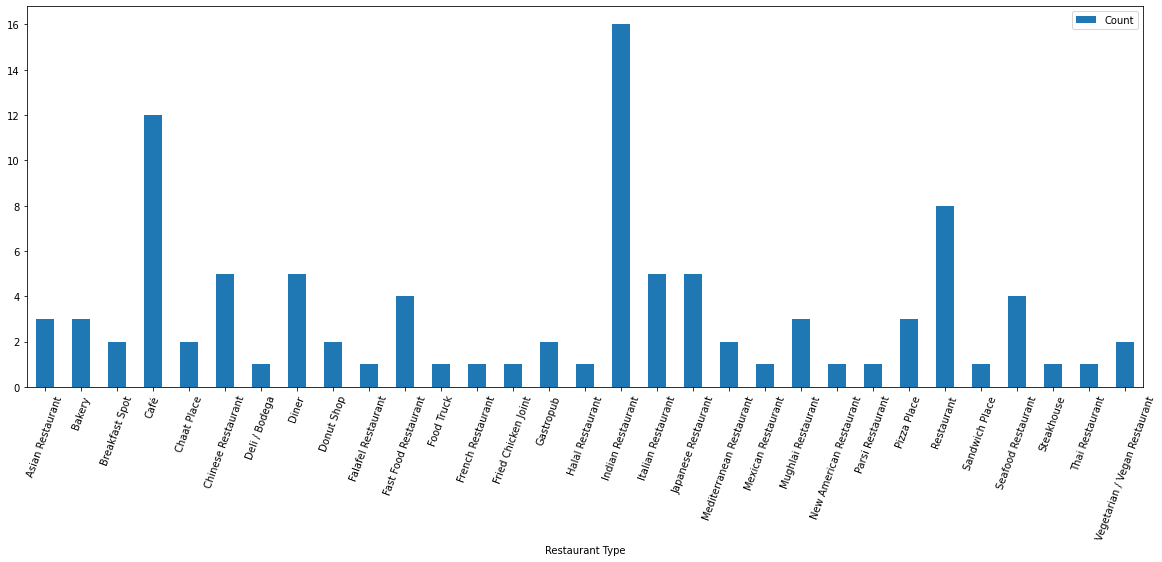

In [41]:
sorted_venues.plot(x='Restaurant Type', y='Count', kind='bar', figsize=(20,7), rot=70)

plt.show()

As we can easily see, Fast Food is the most common restaurant type in Nariman Point, South Mumbai, followed by Pizza. What it appears to be lacking is a Mexican restaurant, so that may be a good target for that neighborhood.

Let's wrap up our work by building a set of functions to easily call for a graph like this one for any neighborhood in the city.

In [42]:
def getCoords(neigh):
    try:
        neigh_id = nola_neigh[nola_neigh['Neighborhood']==neigh].index[0]

        neighborhood_latitude = nola_neigh.loc[neigh_id, 'Latitude'] # neighborhood latitude value
        neighborhood_longitude = nola_neigh.loc[neigh_id, 'Longitude'] # neighborhood longitude value

        neighborhood_name = nola_neigh.loc[neigh_id, 'Neighborhood'] # neighborhood name
        
        return [neighborhood_name,neighborhood_latitude,neighborhood_longitude]
    except:
        return print('Neighborhood name not recognized. Please try again.')

In [43]:
def getVenues(lat,lng,catId,radius=1500):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius,
        catId, # add the category ID to the URL
        LIMIT)

    results = requests.get(url).json()

    venues = results['response']['groups'][0]['items']
    
    nearby_venues = pd.json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

    return(nearby_venues)

In [44]:
def makeGraph(neigh):
    
    coords = getCoords(neigh)
    
    df = getVenues(coords[1],coords[2],'4d4b7105d754a06374d81259')
    
    sorted_venues = df.groupby(['categories']).size().reset_index(name='Count')
    sorted_venues.columns=['Restaurant Type','Count']
    sorted_venues.set_index('Restaurant Type')
    
    sorted_venues.plot(x='Restaurant Type', y='Count', kind='bar', figsize=(20,7), rot=70, title='Restaurants in {}'.format(neigh))

    return plt.show()

In [52]:
neigh = 'Charkop Kandivali West,Western Suburbs'
makeGraph(neigh)

Neighborhood name not recognized. Please try again.


TypeError: 'NoneType' object is not subscriptable

**Methodolgy**
To complete the analysis, there were several steps of data gathering, cleaning, and analysis. Data was pulled from Wikipedia and the FourSquare API, cleaned using the padas and BeautifulSoup libraries, and stored into pandas dataframes. Data was assembled to align latitude and longitude coordinates with neighborhood names in New Orleans, and that was mapped using the folium library.

The Foursquare API was used to find the (up to) 100 closest restaurants to each neighborhood center. That data was used to conduct k-means clustering, organizing the neighborhoods into 7 categories for consideration. These categories were 'Worst Choice', 'Fast Casual Heavy', 'Neighborhood Restaurants', 'Carryout', 'Bad Choice', 'Saturated', and 'Maybe'. Each of these categories represents either the confidence in the choice fo the neighborhood as a site for a new venture ('Bad Choice', 'Worst Choice', 'Maybe') or the predominate type of restaurant in a neighborhood. The 'elbow method' was used to determine the number of clusters used.

This was charted again using the folium library to show both the clustering/category for each neighborhood along with the density of restaraunts in teh form of a heat/bubble map.

The Foursquare API data was then used to develop a charting system to show the relative frequency of each type of restaurant in a given neighborhood.

**Results**
While there is no clear front runner for a possible new restaurant location, the data and visualization provides for easy exploration of that question. If it were up to me, I would locate the restaurant in the Dillard/Gentilly Terrace/Gentilly Woods areas, as those show little competition from 'sit down' restaurants, and much of the rest of the city is either densely packed with restaurants, or too remotely located from the population centers to be worth investment.

The charts below indicate that nicely.

**Restaurant Density Map**

In [ ]:
map_clusters


Dillard Restaraunt Density

In [53]:
neigh = 'Mahavir Nagar, Kandivali West,Western Suburbs'
makeGraph(neigh)

Neighborhood name not recognized. Please try again.


TypeError: 'NoneType' object is not subscriptable

**Discussion**
Much of this work is based on dynamic data sources, so it will need to be run again to get an accurate understanding of the current market. That being said, the author is confident that the work demonstrates an analysis of two key deciding factors for establishing a new business: market need and competition density. You want to land in a spot that allows you to thrive, but that doesn't cut you off from a customer base.

Expansion of the study could include exploring the values of commercial real estate in the neighborhoods as well as the general population of those areas. This would allow for a more robust decision making matrix for potential restaurateurs.

Another possible point of improvement is in the radius/maximum count for the use of the Foursquare API. The values chosen seemingly work well, but there is likely overlap in some of the neighborhoods. More fine tuning to the model would allow for a more accurate picture of each neighborhood. One could also explore the possibility of bounding the neighborhoods and filtering by restaurants that fall within the bounds.

**Conclusion**
Juhu remains a top destination for food tourists and chefs from around the world. The market is open to innovative ideas, and there are untapped local markets that are not far from the tourist destination centers. Not every new restaurant needs to be on river-front property in the Juhu, and there are neighborhoods in need of more options. Exploring these needs can help a new restaurant beat the odds and become a local and tourist hotspot.

